In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
#Calculate the mean and standard deviation for the dataset
import torch
from torchvision import datasets, transforms
from tqdm import tqdm  # for a progress bar

# Assuming your dataset is stored in 'dataset_directory'
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/aps360/ProjectSplits1400/', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize accumulators
mean = 0.0
std = 0.0
nb_samples = 0

for images, _ in tqdm(dataloader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

# Final calculation
mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


In [ ]:
mean = torch.tensor([0.1152,0.1152,0.1152])
std = torch.tensor([0.1977,0.1977,0.1977])
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)])
criterion = nn.CrossEntropyLoss()
train_path = '/content/gdrive/MyDrive/aps360/ProjectSplits1400/Training'
train_set = torchvision.datasets.ImageFolder(root = train_path, transform = transform)

valid_path = '/content/gdrive/MyDrive/aps360/ProjectSplits1400/Validation'
valid_set = torchvision.datasets.ImageFolder(root = valid_path, transform = transform)


# test_path = '/content/gdrive/MyDrive/aps360/ProjectSplits1400/Testing'
# test_set = torchvision.datasets.ImageFolder(root = test_path, transform = transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size =1, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)


In [ ]:
model = torchvision.models.resnet50(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.7MB/s]


In [ ]:
#save ResNet50 features on Google Drive
def saveFeatures(dataloader, folder):
    #prepare dataloader with one of each loaded image
    #dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=1, shuffle=True)

    classes = ['BIRAD1', 'BIRAD2', 'BIRAD3', 'BIRAD4', 'BIRAD5']
    n = 0
    for img, label in dataloader:
        features = model(img)
        #convert to numpy and back to tensor so PyTorch doesn't track updates to ResNet50 weights
        featuresTensor = torch.from_numpy(features.detach().numpy())

        #save features to folder as tensors
        folderName = folder + '/' + str(classes[label])
        if not os.path.isdir(folderName):
            os.mkdir(folderName)
        torch.save(featuresTensor.squeeze(0), folderName + '/' + str(n) + ".tensor")
        n += 1

#load the tensors from files on Google Drive
def loadFeatures(folder):
    dataset = torchvision.datasets.DatasetFolder(folder, loader=torch.load, extensions=('.tensor'))

    #prepare dataloader for verification
    featureLoader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1, shuffle=True)

    #verification step - obtain one batch of features
    dataiter = iter(featureLoader)
    features, labels = next(dataiter)
    print(features.shape)
    print(labels.shape)

    return dataset


In [ ]:
#run this once to save the ResNet50 features to Google Drive

#saveFeatures(train_loader, '/content/gdrive/MyDrive/aps360/Project_tensor/Train')
saveFeatures(valid_loader, '/content/gdrive/MyDrive/aps360/Project_tensor/Validation')


In [ ]:
test_path = '/content/gdrive/MyDrive/aps360/ProjectSplits1400/Testing'
test_set = torchvision.datasets.ImageFolder(root = test_path, transform = transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
saveFeatures(test_loader, '/content/gdrive/MyDrive/aps360/Project_tensor/Test')

In [ ]:
trainingFeatures = loadFeatures('/content/gdrive/MyDrive/aps360/Project_tensor/Train')
testFeatures = loadFeatures('/content/gdrive/MyDrive/aps360/Project_tensor/Test')
validationFeatures = loadFeatures('/content/gdrive/MyDrive/aps360/Project_tensor/Validation')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b45ac1904c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


torch.Size([32, 1000])
torch.Size([32])
torch.Size([32, 1000])
torch.Size([32])


FileNotFoundError: ignored

In [ ]:
classes = ['BIRAD1','BIRAD2','BIRAD3','BIRAD4','BIRAD5']
def features_to_folder(loader, path, model):
    n = 0
    for img, label in loader:
        print(n)
        model.eval()
        with torch.no_grad():
            features = model(img)
        features_tensor = torch.from_numpy(features.detach().numpy)
        features_tensor = features.squeeze(0)
        folder_name = path + '/'+ str(classes[label.item()])
        if not os.path.isdir(folder_name):
            os.makedirs(folder_name)
        torch.save(features_tensor, folder_name + '/' + str(n) + '.tensor')

        n += 1

In [ ]:

class ClassifierCNN(nn.Module):
    def __init__(self,name = "ClassifierCNN"):
        super(ClassifierCNN, self).__init__()
        # The input features are 1000-dimensional
        self.name = "ClassiferCNN"
        self.fc1 = nn.Linear(1000, 500)  # First fully connected layer
        self.fc2 = nn.Linear(500, 128)   # Second fully connected layer
        self.fc3 = nn.Linear(128, 5)     # Final layer for 5 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))  # Applying ReLU activation function after first FC layer
        x = F.relu(self.fc2(x))  # Applying ReLU activation function after second FC layer
        x = self.fc3(x)  # No activation function here, raw scores output
        return x



In [ ]:
# def get_accuracy(model, data_loader):

#     correct = 0
#     total = 0
#     for imgs, labels in data_loader:

#         if True and torch.cuda.is_available():
#           imgs = imgs.cuda()
#           labels = labels.cuda()

#         output = model(imgs)

#         #select index with maximum prediction score (This is for multi-class)
#         pred = output.max(1, keepdim=True)[1]
#         correct += pred.eq(labels.view_as(pred)).sum().item()
#         total += imgs.shape[0]

#     return (correct / total)
def get_accuracy(model, data_loader, return_cm=False):
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    for imgs, labels in data_loader:
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / total
    if return_cm:
        cm = confusion_matrix(all_labels, all_preds)
        return accuracy, cm

    return accuracy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
def get_model_name(name, batch_size, lr, num_epochs):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_num_epoch{3}".format(name,
                                                   batch_size,
                                                   lr,
                                                   num_epochs)
    return path

In [ ]:
def plot_all_confusion_matrices(confusion_matrices, classes, set_title='Training', cmap=plt.cm.Blues):
    num_epochs = len(confusion_matrices)
    fig, axes = plt.subplots(nrows=1, ncols=num_epochs, figsize=(num_epochs * 5, 4), sharey=True)

    for idx, cm in enumerate(confusion_matrices):
        ax = axes[idx]
        sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=ax)
        ax.set_title(f'Epoch {idx+1}')
        ax.set_xlabel('Predicted Label')
        if idx == 0:
            ax.set_ylabel('True Label')
        ax.set_xticklabels(classes, rotation=45)
        ax.set_yticklabels(classes, rotation=45)

    plt.suptitle(f'{set_title} Confusion Matrices Over Epochs')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def plot_last_confusion_matrix(confusion_matrix, classes, set_title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=cmap)
    plt.title(f'{set_title} - Last Epoch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=45)
    plt.show()

In [ ]:
# Training Code

def train_p(model, train_set, val_set, batch_size=64, num_epochs=32, lr=0.001):
    torch.manual_seed(10)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    iters, losses, train_acc, val_acc = [], [], [], []


    # To store confusion matrices
    all_train_cm = []
    all_val_cm = []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            if True and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        model_path = get_model_name(model.name, batch_size, lr, epoch)
        torch.save(model.state_dict(), model_path)

        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        # train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        # val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy

        train_accuracy, train_cm = get_accuracy(model, train_loader, return_cm=True)
        val_accuracy, val_cm = get_accuracy(model, val_loader, return_cm=True)

        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        all_train_cm.append(train_cm)
        all_val_cm.append(val_cm)




        n += 1

    epochs = np.arange(1, num_epochs + 1)
    # Save confusion matrices
    np.save("train_confusion_matrices.npy", all_train_cm)
    np.save("val_confusion_matrices.npy", all_val_cm)
    # Load saved confusion matrices
    train_confusion_matrices = np.load('train_confusion_matrices.npy', allow_pickle=True)
    val_confusion_matrices = np.load('val_confusion_matrices.npy', allow_pickle=True)


    # Plotting

    return train_acc, val_acc, epochs

In [ ]:
train_path = '/content/gdrive/MyDrive/aps360/Project_tensor/Train'
train_set_t = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))

valid_path = '/content/gdrive/MyDrive/aps360/Project_tensor/Validation'
valid_set_t = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))

train_loader = torch.utils.data.DataLoader(train_set_t, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set_t, batch_size=32, shuffle=True)

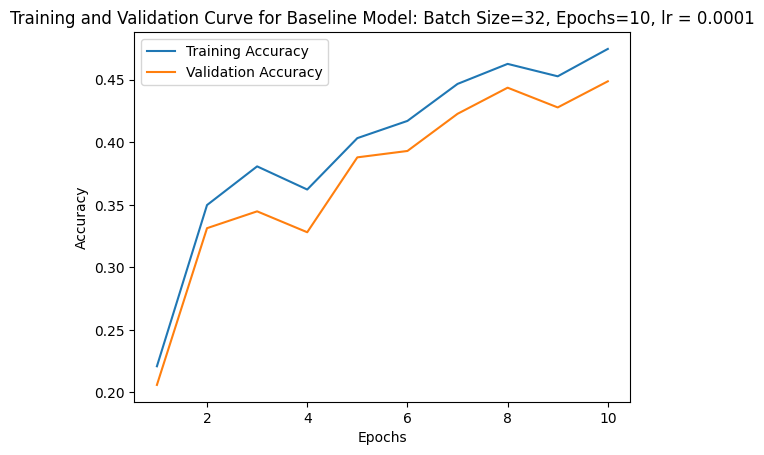

In [ ]:
model1 = ClassifierCNN(name="Classifier1")
if True and torch.cuda.is_available():
  model1.cuda()

train_acc, val_acc, epochs = train_p(model1, train_set_t, valid_set_t, batch_size = 32, num_epochs = 10, lr = 0.0001)



plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=10, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

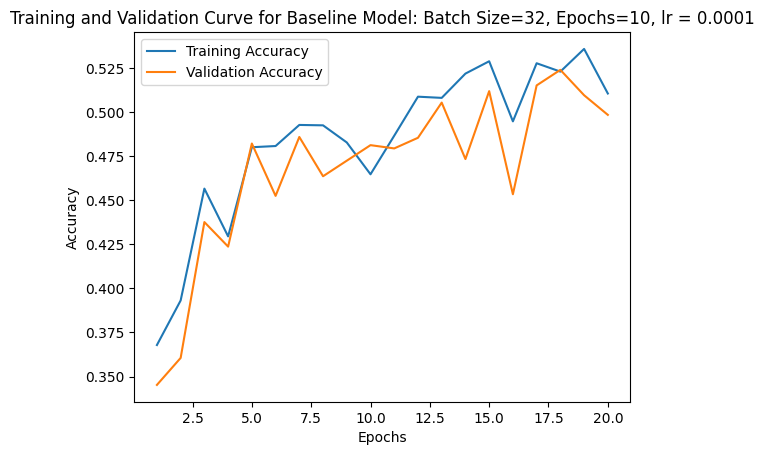

In [ ]:
model1 = ClassifierCNN(name="Classifier2")
if True and torch.cuda.is_available():
  model1.cuda()

train_acc, val_acc, epochs = train_p(model1, train_set_t, valid_set_t, batch_size = 32, num_epochs = 20, lr = 0.001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=10, lr = 0.0001")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
final_model = ClassifierCNN(name="Classifier1")
if True and torch.cuda.is_available():
  final_model.cuda()
final_model.eval()
valid_loader = torch.utils.data.DataLoader(valid_set_t, batch_size=32, shuffle=False)

true_labels_val = []
predicted_labels_val = []

for image, label in valid_loader:

  if True and torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  # image = model(image)
  pred = final_model(image)
  pred = torch.argmax(pred, dim=1)
  true_labels_val.extend(label.tolist())
  predicted_labels_val.extend(pred.tolist())

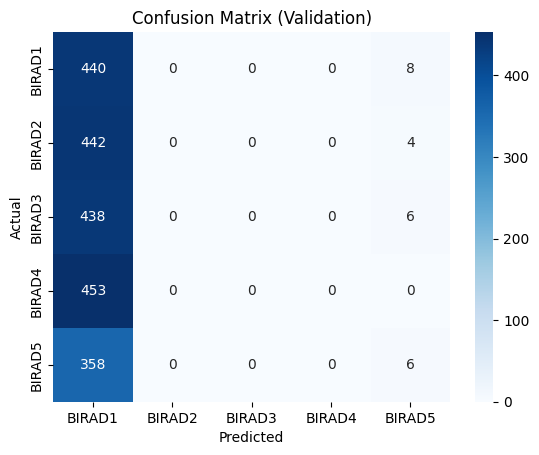

In [ ]:
# Compute and print the confusion matrix
cm = confusion_matrix(true_labels_val, predicted_labels_val)

classes = ["BIRAD1", "BIRAD2", "BIRAD3", "BIRAD4", "BIRAD5"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


precision = precision_score(true_labels_val, predicted_labels_val, average='weighted')
recall = recall_score(true_labels_val, predicted_labels_val, average='weighted')
f1 = f1_score(true_labels_val, predicted_labels_val, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Alternatively, you can use classification_report for a detailed report
report = classification_report(true_labels_val, predicted_labels_val, target_names=classes)
print(report)

Precision: 0.0466
Recall: 0.1306
F1 Score: 0.0599
              precision    recall  f1-score   support

      BIRAD1       0.00      0.00      0.00       361
      BIRAD2       0.05      0.21      0.08        71
      BIRAD3       0.17      0.66      0.26       163
      BIRAD4       0.00      0.00      0.00       304
      BIRAD5       0.15      0.08      0.10       112

    accuracy                           0.13      1011
   macro avg       0.07      0.19      0.09      1011
weighted avg       0.05      0.13      0.06      1011



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
final_model = ClassifierCNN(name="Classifier1")
if True and torch.cuda.is_available():
  final_model.cuda()

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

true_labels_val = []
predicted_labels_val = []

for image, label in test_loader:

  if True and torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  image = model(image)
  pred = final_model(image)
  pred = torch.argmax(pred, dim=1)
  true_labels_val.extend(label.tolist())
  predicted_labels_val.extend(pred.tolist())

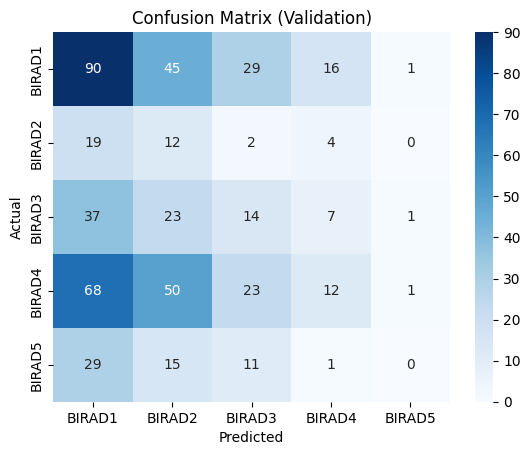

In [ ]:
# Compute and print the confusion matrix
cm = confusion_matrix(true_labels_val, predicted_labels_val)

classes = ["BIRAD1", "BIRAD2", "BIRAD3", "BIRAD4", "BIRAD5"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


precision = precision_score(true_labels_val, predicted_labels_val, average='weighted')
recall = recall_score(true_labels_val, predicted_labels_val, average='weighted')
f1 = f1_score(true_labels_val, predicted_labels_val, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Alternatively, you can use classification_report for a detailed report
report = classification_report(true_labels_val, predicted_labels_val, target_names=classes)
print(report)

Precision: 0.2565
Recall: 0.2510
F1 Score: 0.2256
              precision    recall  f1-score   support

      BIRAD1       0.37      0.50      0.42       181
      BIRAD2       0.08      0.32      0.13        37
      BIRAD3       0.18      0.17      0.17        82
      BIRAD4       0.30      0.08      0.12       154
      BIRAD5       0.00      0.00      0.00        56

    accuracy                           0.25       510
   macro avg       0.19      0.21      0.17       510
weighted avg       0.26      0.25      0.23       510



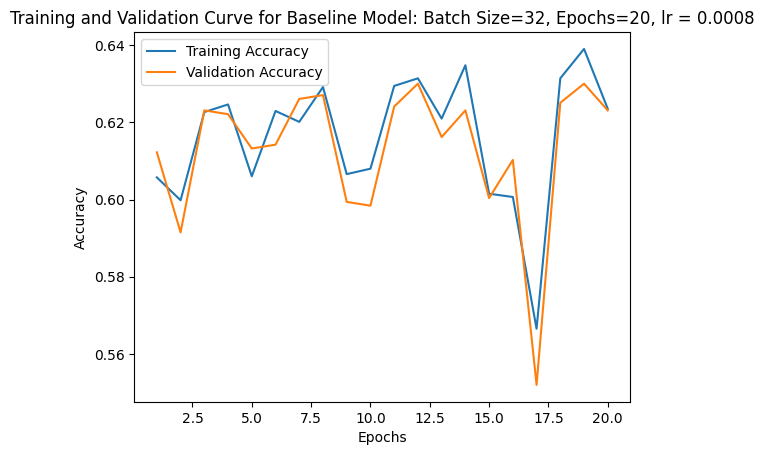

In [ ]:
model2 = ClassifierCNN(name="Classifier2")
if True and torch.cuda.is_available():
  model1.cuda()

train_acc, val_acc, epochs = train_p(model1, train_set_t, valid_set_t, batch_size = 32, num_epochs = 20, lr = 0.0008)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=20, lr = 0.0008")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
final_model = ClassifierCNN(name="Classifier3")
if True and torch.cuda.is_available():
  final_model.cuda()

# val_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
test_path = '/content/gdrive/MyDrive/aps360/Tensor/Test'
test_set_t = torchvision.datasets.DatasetFolder(test_path, loader=torch.load, extensions=('.tensor'))

test_loader = torch.utils.data.DataLoader(test_set_t, batch_size=32, shuffle=False)
true_labels_val = []
predicted_labels_val = []

for image, label in test_loader:

  if True and torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #model.to(device)
  image = model(image)
  pred = final_model(image)
  pred = torch.argmax(pred, dim=1)
  true_labels_val.extend(label.tolist())
  predicted_labels_val.extend(pred.tolist())

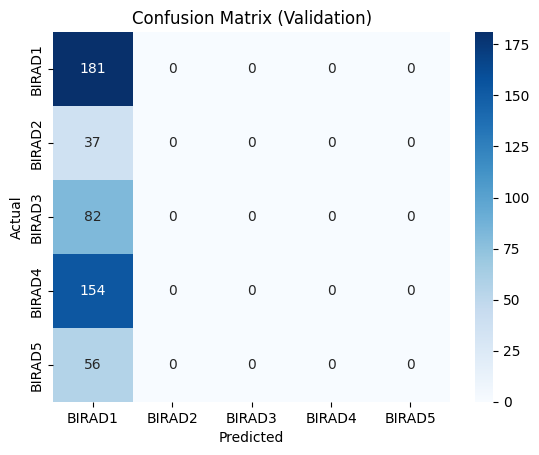

In [ ]:
# Compute and print the confusion matrix
cm = confusion_matrix(true_labels_val, predicted_labels_val)

classes = ["BIRAD1", "BIRAD2", "BIRAD3", "BIRAD4", "BIRAD5"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

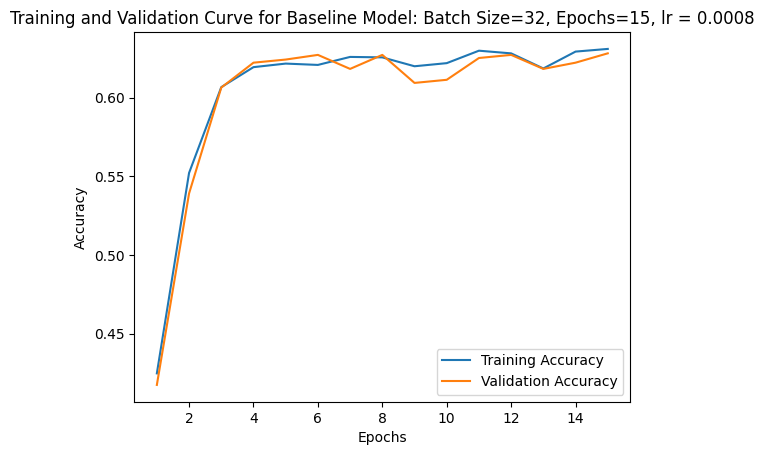

In [ ]:
model3 = ClassifierCNN(name="Classifier3")
if True and torch.cuda.is_available():
  model1.cuda()

train_acc, val_acc, epochs = train_p(model3, train_set_t, valid_set_t, batch_size = 32, num_epochs = 15, lr = 0.0008)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=15, lr = 0.0008")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

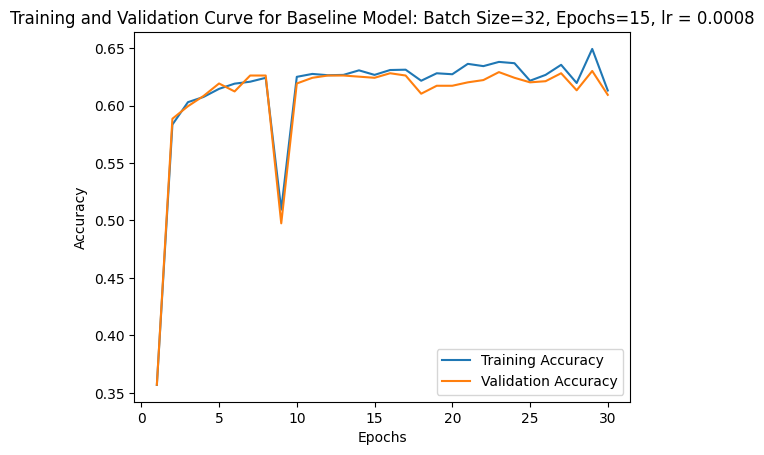

In [ ]:
model4 = ClassifierCNN(name="Classifier4")
if True and torch.cuda.is_available():
  model1.cuda()

train_acc, val_acc, epochs = train_p(model4, train_set_t, valid_set_t, batch_size = 64, num_epochs = 30, lr = 0.0008)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=15, lr = 0.0008")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

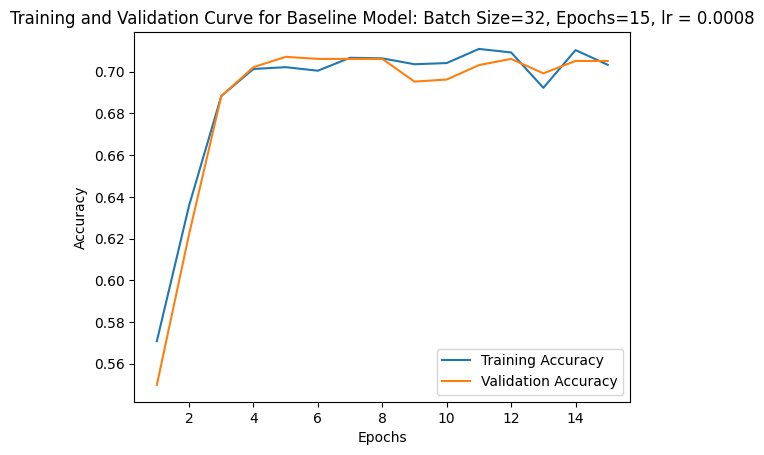

In [ ]:
model5 = ClassifierCNN(name="Classifier5")
if True and torch.cuda.is_available():
  model1.cuda()

train_acc, val_acc, epochs = train_p(model5, train_set_t, valid_set_t, batch_size = 32, num_epochs = 15, lr = 0.0008)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=15, lr = 0.0008")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

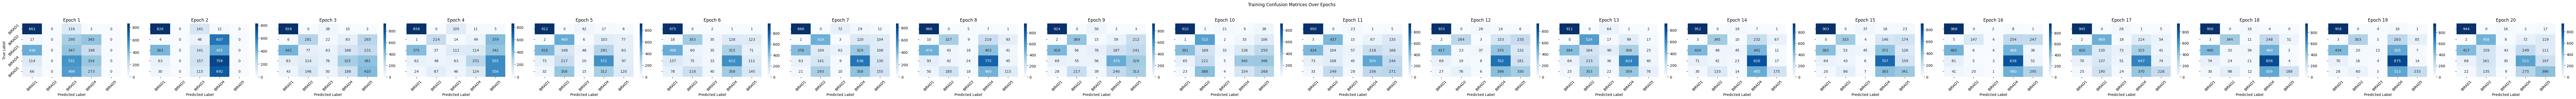

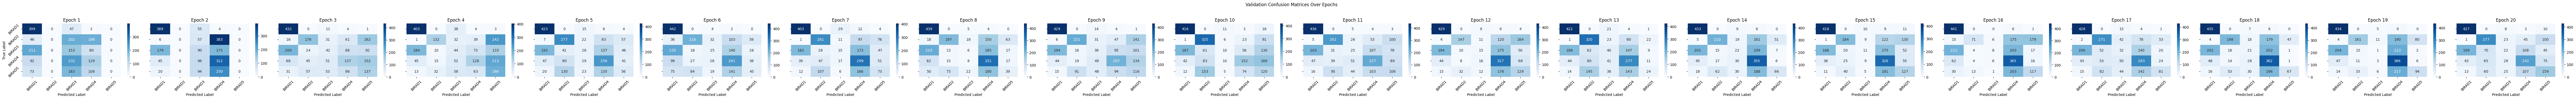

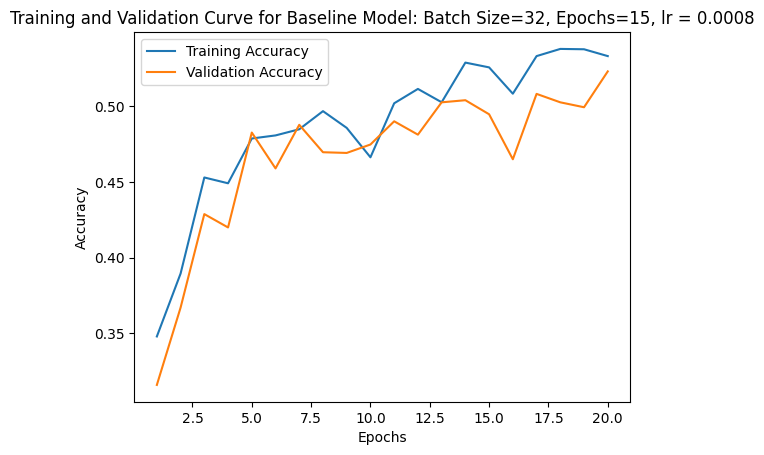

In [ ]:
model6 = ClassifierCNN(name="Classifier6")
if True and torch.cuda.is_available():
  model1.cuda()
model6.to(device)
train_acc, val_acc, epochs = train_p(model6, train_set_t, valid_set_t, batch_size = 32, num_epochs = 20, lr = 0.0008)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=20, lr = 0.0008")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


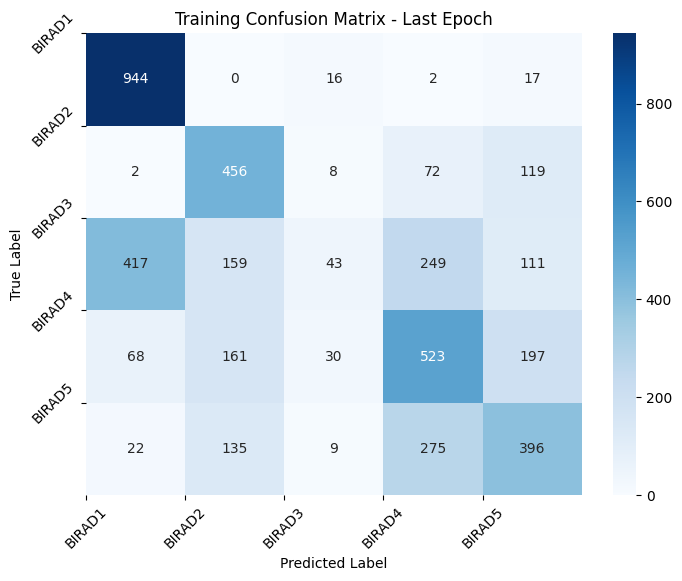

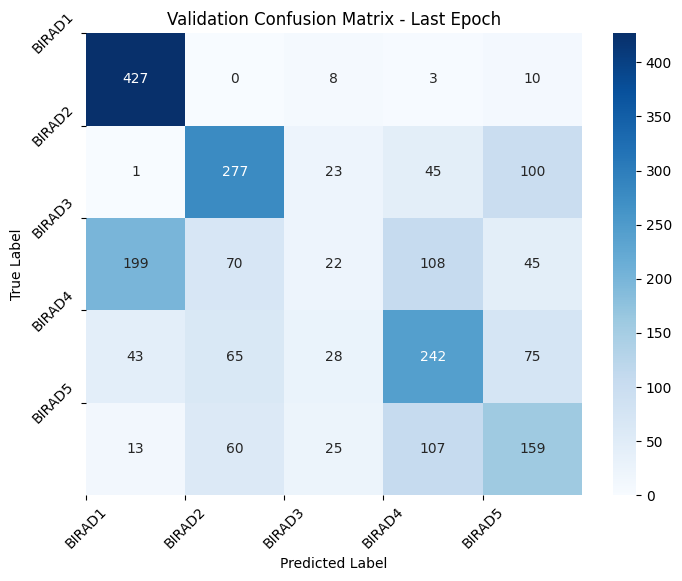

In [ ]:
train_confusion_m = np.load('/content/train_confusion_matrices.npy')
val_confusion_m = np.load('/content/val_confusion_matrices.npy')
class_names = ['BIRAD1','BIRAD2','BIRAD3','BIRAD4','BIRAD5']
plot_last_confusion_matrix(train_confusion_m[-1], class_names, set_title='Training Confusion Matrix')
plot_last_confusion_matrix(val_confusion_m[-1], class_names, set_title='Validation Confusion Matrix')

In [ ]:
model7 = ClassifierCNN(name="Classifier7")
if True and torch.cuda.is_available():
  model1.cuda()
model6.to(device)
train_acc, val_acc, epochs = train_p(model6, train_set_t, valid_set_t, batch_size = 64, num_epochs = 20, lr = 0.001)

plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")

plt.title("Training and Validation Curve for Baseline Model: Batch Size=32, Epochs=20, lr = 0.0008")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


NameError: ignored

In [ ]:
inal_model = ClassifierCNN(name="Classifier6")
if True and torch.cuda.is_available():
  final_model.cuda()
final_model.eval()
valid_loader = torch.utils.data.DataLoader(valid_set_t, batch_size=32, shuffle=False)

true_labels_val = []
predicted_labels_val = []

for image, label in valid_loader:

  if True and torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  # image = model(image)
  pred = final_model(image)
  pred = torch.argmax(pred, dim=1)
  true_labels_val.extend(label.tolist())
  predicted_labels_val.extend(pred.tolist())

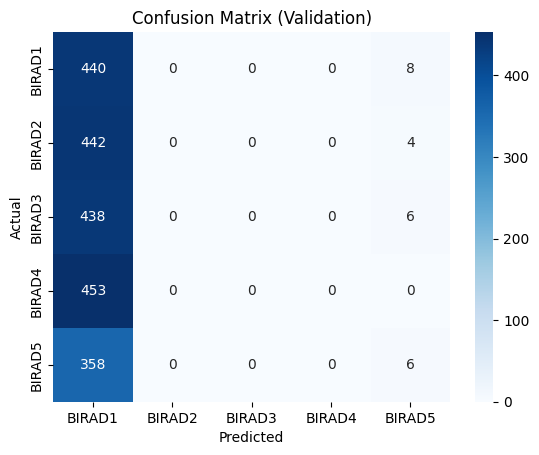

In [ ]:
# Compute and print the confusion matrix
cm = confusion_matrix(true_labels_val, predicted_labels_val)

classes = ["BIRAD1", "BIRAD2", "BIRAD3", "BIRAD4", "BIRAD5"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
def verifyImages(dataset):
    #prepare dataloader
    dataLoader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=1, shuffle=True)

    #verification step - obtain one batch of images
    dataiter = iter(dataLoader)
    images, labels = dataiter.next()
    images = images.numpy() #convert images to numpy for display
    classes = ["Not Rainy", "Rainy"]

    #plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(6):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture = np.transpose(images[idx], (1, 2, 0))
        picture = std * picture + mean
        picture = np.clip(picture, 0, 1)
        plt.imshow(picture)
        ax.set_title(classes[labels[idx]])



def loadImages(folder):
    #transform to tensor and normalize
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])

    #load data from Google Drive and clean them as they load
    dataset = torchvision.datasets.ImageFolder(root=folder, transform=transform)

    return dataset

In [ ]:
data = loadImages("/content/gdrive/My Drive/aps360/ProjectSplits1400/Train/BIRAD1")
verifyImages(data)

FileNotFoundError: ignored

## Here are ----------------------------------------------------

In [ ]:

def train(model, train_dataset, valid_dataset, batch_size=32, learning_rate=0.001, num_epochs=1):
    # Prepare Dataloader
    num_workers = 1
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print(len(train_loader))
    print(len(valid_loader))
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for features, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if True and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################


            out = model(features)      # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, valid_loader, train=True)) # compute training accuracy
        print("epoch number ", epoch+1, "accuracy: ",train_acc[epoch])
        val_acc.append(get_accuracy(model, train_loader, valid_loader, train=False))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)


    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
train_path = '/content/gdrive/MyDrive/aps360/Project_tensor/Train'
train_set_t = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))

valid_path = '/content/gdrive/MyDrive/aps360/Project_tensor/Validation'
valid_set_t = torchvision.datasets.DatasetFolder(valid_path, loader=torch.load, extensions=('.tensor'))

train_loader = torch.utils.data.DataLoader(train_set_t, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set_t, batch_size=32, shuffle=True)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
# test_path = '/content/gdrive/MyDrive/aps360/Project/Final_Test'
# test_set_t = torchvision.datasets.DatasetFolder(train_path, loader=torch.load, extensions=('.tensor'))


111
111
epoch number  1 accuracy:  0.5859926574414007
epoch number  2 accuracy:  0.6181869528381813
epoch number  3 accuracy:  0.6229878565377012
epoch number  4 accuracy:  0.6012425868398757
epoch number  5 accuracy:  0.6275063541372493
epoch number  6 accuracy:  0.6286359785371364
epoch number  7 accuracy:  0.6224230443377577
epoch number  8 accuracy:  0.6006777746399322
epoch number  9 accuracy:  0.6212934199378707
epoch number  10 accuracy:  0.6300480090369952
epoch number  11 accuracy:  0.6263767297373624
epoch number  12 accuracy:  0.6289183846371081
epoch number  13 accuracy:  0.6190341711380966
epoch number  14 accuracy:  0.618469358938153
epoch number  15 accuracy:  0.6323072578367692
epoch number  16 accuracy:  0.6308952273369105
epoch number  17 accuracy:  0.6311776334368823
epoch number  18 accuracy:  0.5763908500423609
epoch number  19 accuracy:  0.5975713075402429
epoch number  20 accuracy:  0.6379553798362044


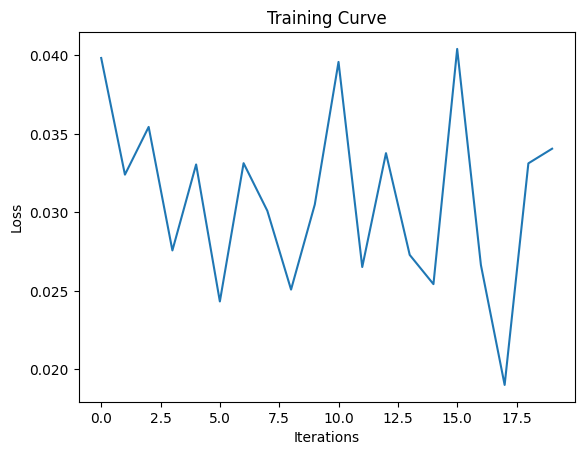

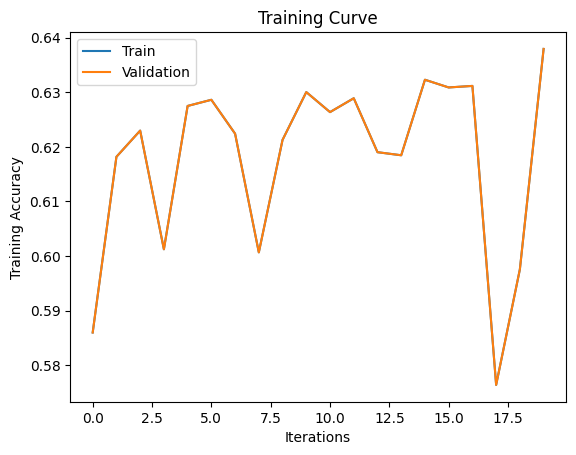

Final Training Accuracy: 0.6379553798362044
Final Validation Accuracy: 0.6379553798362044


In [ ]:
model = ClassifierCNN()
model = model.to(device)
train(model,train_set_t,valid_set_t, learning_rate = 0.001, num_epochs = 15)

# ----------------------------------------------------------------
